## QUESTION 3 ##

## Step 1 Ideation ##

For this project, I have selected Tesla (TSLA) stock as the subject of study, covering the period from May 2018 to May 2024. The goal is to predict short-term (daily) stock price movements, specifically identifying whether the stock price will go up (label 1) or down (label 0). The prediction is framed as a binomial classification problem using a Support Vector Machine (SVM) model.

## Step 2 Data Collection

The dataset consists of daily closing prices of Tesla stock from May 2018 to May 2024. This data will be sourced and downloaded from reliable financial databases -- GitHub

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Base Libraries
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
# Classifier
from sklearn.linear_model import LogisticRegression
# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, TimeSeriesSplit)
# Metrics
from sklearn.metrics import (accuracy_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay, log_loss)

In [2]:
!pip install --upgrade ipywidgets
!pip install --upgrade jupyterlab
!jupyter labextension install @jupyter-widgets/jupyterlab-manager@2.0

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
C:\Users\Lenovo\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
C:\Users\Lenovo\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
C:\Users\Lenovo\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:56: UserWarning: See the log file for details: C:\Users\Lenovo\AppData\Local\Temp\jupyterlab-debug-zrgob_gu.log
  warnings.warn(f"See 

In [3]:
df = pd.read_csv('TSLA.csv', index_col=0, parse_dates=True, dayfirst=True)
df.head(2)

,Open,High,Low,Close,Volume
Date,,,,,
2018-05-25,18.508667,18.642668,18.374001,18.590000,58126500
2018-05-29,18.567333,19.100000,18.410000,18.917334,84999000


In [4]:
# Get Info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2018-05-25 to 2024-05-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


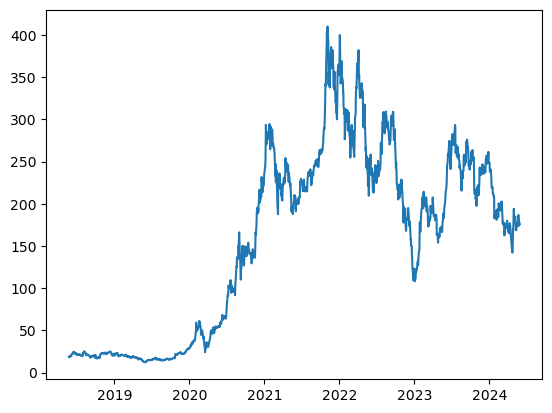

In [5]:
# Visualize data
plt.plot(df['Close'])

## Step 3 Exploratory Data Analysis ##

In [6]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1511.0,1.569876e+02,1.090148e+02,1.207333e+01,2.400000e+01,1.815000e+02,2.420450e+02,4.114700e+02
High,1511.0,1.604714e+02,1.113582e+02,1.244533e+01,2.440700e+01,1.851000e+02,2.469950e+02,4.144967e+02
Low,1511.0,1.532275e+02,1.063793e+02,1.179933e+01,2.344167e+01,1.771400e+02,2.370583e+02,4.056667e+02
Close,1511.0,1.569302e+02,1.088751e+02,1.193133e+01,2.389600e+01,1.808300e+02,2.422950e+02,4.099700e+02
Volume,1511.0,1.327153e+08,8.284740e+07,2.444082e+07,8.199180e+07,1.090150e+08,1.532946e+08,9.140820e+08


## Step 4 Cleaning Dataset ##

In [7]:
# Check for missing values
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Data already cleaned, no further imputation required

## Step 5 Transformation ##

In [8]:
# Create Features
# Calculate the difference between the high and close prices
df['HC'] = df['High'] - df['Close']

# Calculate the daily logarithmic returns
df['RET'] = np.log(df['Close'] / df['Close'].shift(1))

# Calculate the ratio of the close price to the 7-day rolling mean of close prices
df['MA7'] = df['Close'] / df['Close'].rolling(7).mean()

# Calculate the ratio of volume to the 7-day rolling mean of volume
df['VMA'] = df['Volume'] / df['Volume'].rolling(7).mean()

# Calculate the ratio of the close price to the open price minus 1
df['OC_'] = df['Close'] / df['Open'] - 1

# Calculate the 7-day rolling mean of the ratio of close price to open price
df['OC'] = df['OC_'].rolling(7).mean()

# Calculate the 14-day rolling mean of the ratio of close price to open price (overwrites the previous definition of OC)
df['OC'] = df['OC_'].rolling(14).mean()

# Calculate the ratio of the high price to the low price minus 1
df['HC_'] = df['High'] / df['Low'] - 1

# Calculate the 7-day rolling mean of the ratio of high price to low price
df['HC'] = df['HC_'].rolling(7).mean()

# Calculate the ratio of the open price to the previous day's close price minus 1
df['GAP_'] = df['Open'] / df['Close'].shift(1) - 1

# Calculate the 7-day rolling mean of the ratio of open price to previous day's close price
df['GAP'] = df['GAP_'].rolling(7).mean()

# Calculate the 7-day rolling standard deviation of the logarithmic returns
df['STD'] = df['RET'].rolling(7).std()

# Calculate the 7-day rolling mean of the close price plus the 7-day rolling standard deviation of the close price
df['UB'] = df['Close'].rolling(7).mean() + df['Close'].rolling(7).std()

# Calculate Open - Close
df['O-C'] = df['Open'] - df['Close']

# Calculate High - Low
df['H-L'] = df['High'] - df['Low']

# Calculate the sign of return or momentum
df['Sign'] = np.sign(np.log(df['Close'] / df['Close'].shift(1)))

# Calculate the Momentum: price change over k period
k = 7  # Now I set five days as a period
df['Momentum'] = df['Close'] - df['Close'].shift(k)

# Calculate the Simple Moving Average (SMA)
n = 7  # Now I calculate the average price for ten days 
df['SMA'] = df['Close'].rolling(window=n).mean()

# Calculate the Exponential Moving Average (EMA)
Nobs = 10  # Now I calculate the average price for ten days 
alpha = 2 / (Nobs + 1)
df['EMA'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()

df.dropna(inplace=True)

features = df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'OC_', 'HC_', 'GAP_'], axis=1)
features.head(2)

,HC,RET,MA7,VMA,OC,GAP,STD,UB,O-C,H-L,Sign,Momentum,SMA,EMA
Date,,,,,,,,,,,,,,
2018-06-14,0.043317,0.036844,1.074409,0.790004,0.011267,0.014839,0.034383,23.267760,-0.672667,0.810001,1.0,4.439333,22.196381,21.734160
2018-06-15,0.036918,0.001257,1.058203,0.849605,0.011827,0.008692,0.020994,23.716623,-0.288667,0.894665,1.0,2.578001,22.564666,22.123949


In [9]:
# Specific X
X = features.values

In [10]:
# Assume 'returns' is a list/array containing daily returns
# Set threshold for small positive returns
# Small positive returns below 0.25% can be labelled as negative
threshold = 0.0025  # 0.25%

# Apply labeling rule
y = np.where(df['Close'].shift(-1)>1.0025*df['Close'],1,0)

In [11]:
 # Check Class Imbalance
pd.Series(y).value_counts()

0    774
1    724
Name: count, dtype: int64

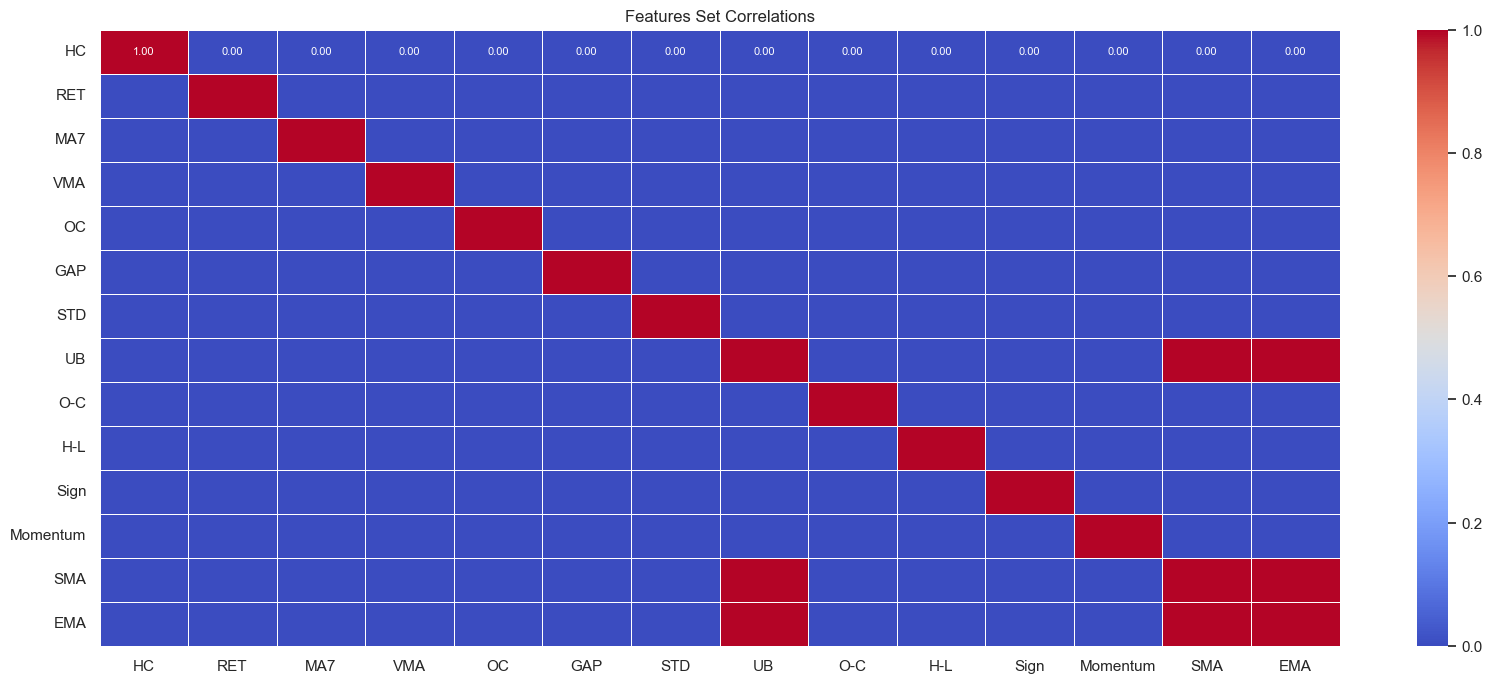

In [12]:
!pip install seaborn
import seaborn as sns
# Set seaborn style
sns.set(style="whitegrid", rc={'figure.figsize': (20, 8)})

# Remove features that are highly correlated
sns.heatmap(features.corr() > 0.9,
            annot=True,
            annot_kws={"size": 8},
            fmt=".2f",
            linewidths=.5,
            cmap="coolwarm",
            cbar=True)

plt.title('Features Set Correlations')
plt.show()

In [13]:
# remove the first feature that is correlated with any other feature
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = features.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [14]:
# total correlated features
drop_correlated_features = correlated_features(features)
# drop the highly correlated features
X = features.drop(drop_correlated_features, axis=1)
# record feature names
feature_names = X.columns

In [15]:
X

,HC,RET,MA7,VMA,OC,GAP,STD,UB,O-C,H-L,Sign,Momentum
Date,,,,,,,,,,,,
2018-06-14,0.043317,0.036844,1.074409,0.790004,0.011267,0.014839,0.034383,23.267760,-0.672667,0.810001,1.0,4.439333
2018-06-15,0.036918,0.001257,1.058203,0.849605,0.011827,0.008692,0.020994,23.716623,-0.288667,0.894665,1.0,2.578001
2018-06-18,0.037187,0.034736,1.070865,0.970198,0.013582,0.009085,0.018057,24.275365,-1.028667,1.282000,1.0,3.649334
2018-06-19,0.043684,-0.050551,1.003632,0.974562,0.008989,0.005586,0.033116,24.259494,0.840668,1.583336,-1.0,2.325998
2018-06-20,0.043322,0.027059,1.018682,0.675597,0.010440,0.005629,0.031120,24.359392,-0.278668,0.825333,1.0,2.008002
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-21,0.038300,0.064467,1.055703,1.474155,0.000349,0.004931,0.028796,181.520347,-11.090011,12.169998,1.0,18.130005
2024-05-22,0.037446,-0.035400,1.012260,1.087154,0.000392,0.000763,0.034169,182.292035,2.740005,5.680008,-1.0,8.220002
2024-05-23,0.040122,-0.036008,0.979455,0.909103,-0.002417,-0.000066,0.035347,182.031256,8.059998,8.639999,-1.0,-3.809998


In [16]:
# EDA for Feature Scaling
# decide which scaling to use
X.describe()

,HC,RET,MA7,VMA,OC,GAP,STD,UB,O-C,H-L,Sign,Momentum
count,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000
mean,0.047132,0.001358,1.004783,1.004210,0.000665,0.001582,0.035854,163.923026,0.059541,7.300285,0.043391,0.732206
std,0.018009,0.040471,0.056166,0.313539,0.007929,0.009336,0.018357,112.595537,6.115485,6.504909,0.999058,19.032427
min,0.016798,-0.236518,0.697871,0.297502,-0.030357,-0.039171,0.006885,12.837572,-33.460007,0.206667,-1.000000,-72.173340
25%,0.035318,-0.019444,0.972901,0.818688,-0.004225,-0.004038,0.023131,24.793390,-2.057499,1.269668,-1.000000,-6.394993
50%,0.043028,0.001598,1.004321,0.955667,0.000969,0.001148,0.032823,189.402384,-0.030335,6.348343,1.000000,0.363335
75%,0.055039,0.020567,1.034341,1.125998,0.005568,0.006337,0.043432,250.117079,1.918665,10.592502,1.000000,8.169998
max,0.163662,0.181445,1.331251,3.366102,0.025591,0.055096,0.144067,415.990154,50.033356,54.326660,1.000000,104.863342


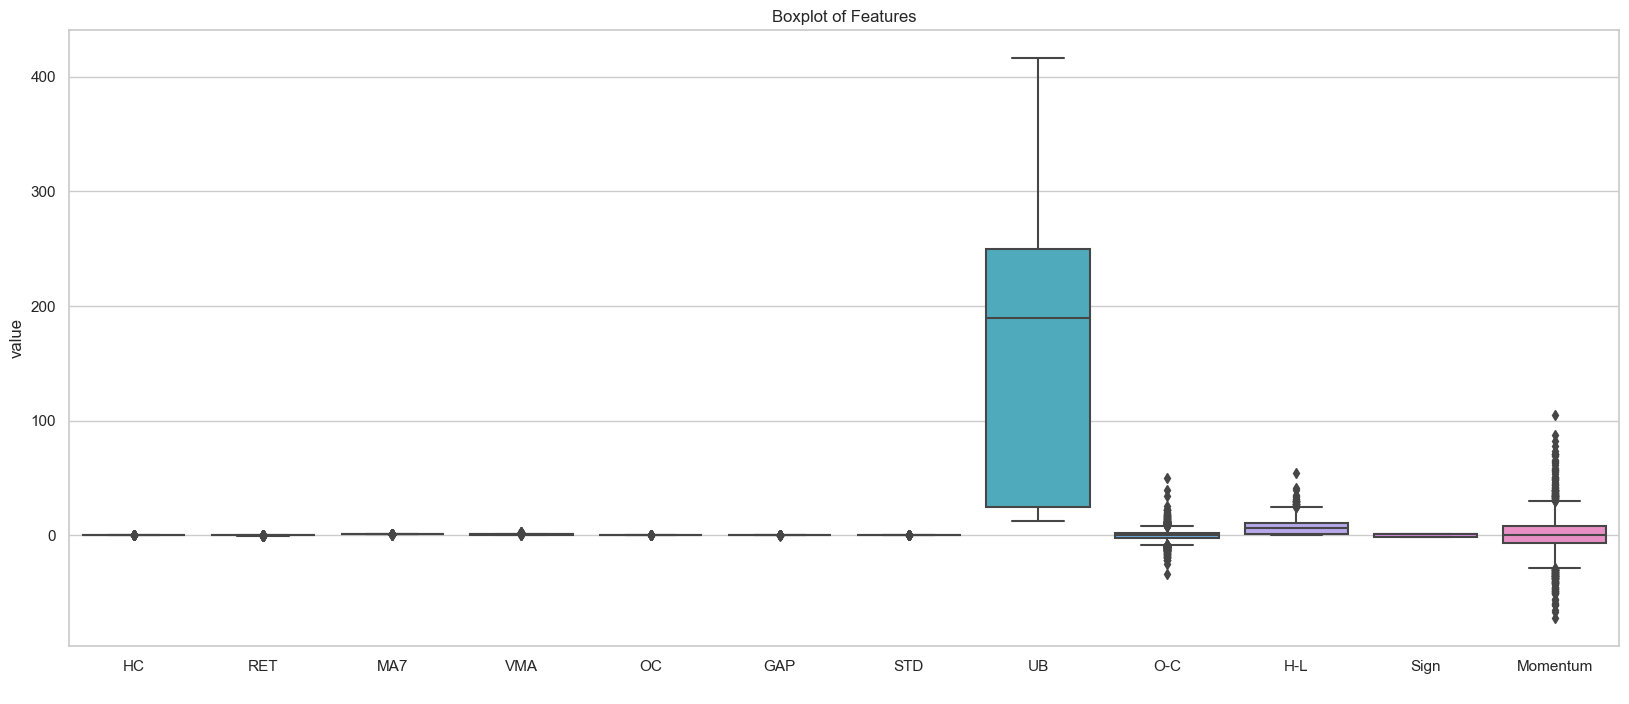

In [17]:
# study the distribution
# fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(x='variable', y='value', data=pd.melt(X))
plt.xlabel(' ')
plt.title('Boxplot of Features');

I choose Standard Scaling for the following three reasons:

1. Feature Value Range: By observing the box plots of each feature's value range, as shown in the figure, because most features have similar value ranges, this indicates that the differences between features are not significant. This consistency in value scales suggests that standardization is appropriate.

2. Median and Interquartile Range: Observing the box plots for the median (the line within the box) and the interquartile range (the box itself) of each feature, as shown in the figure, because these features are similar, it indicates that the distributions of the features are not significantly different. Standardizing these features will lead to more uniform distributions, benefiting model training.

3. Symmetry of Data Distribution: Standard Scaling assumes that the data approximately follows a normal distribution. By observing the symmetry of the data distributions in the box plots, as shown in the figure, because most features are symmetrically distributed, it indicates that the data is not heavily skewed. This makes standardization a suitable choice to ensure that the features are on the same scale, improving model performance.

## Step 6 Modeling ##

Use a Support Vector Machine (SVM) for classification.

In [18]:
# Split the Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Define an SVM Model with Standard Scaling
classifier = Pipeline([
    ("scaler", StandardScaler()), 
    ("classifier", SVC(probability=True, class_weight='balanced'))  # SVM with class balancing
])

# Fit the SVM Model
classifier.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(class_weight='balanced', probability=True))])

In [20]:
# Verify Class Labels
classifier.classes_

array([0, 1])

In [21]:
 # Predict the Class Labels
y_pred = classifier.predict(X_test)
y_pred[-20:]

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [22]:
 # Predict Probabilities
y_proba = classifier.predict_proba(X_test)
y_proba[-20:]

array([[0.53426802, 0.46573198],
       [0.53911136, 0.46088864],
       [0.52356346, 0.47643654],
       [0.5       , 0.5       ],
       [0.50552401, 0.49447599],
       [0.49441843, 0.50558157],
       [0.52300587, 0.47699413],
       [0.51300745, 0.48699255],
       [0.50771125, 0.49228875],
       [0.5       , 0.5       ],
       [0.49120581, 0.50879419],
       [0.5       , 0.5       ],
       [0.48715109, 0.51284891],
       [0.48807399, 0.51192601],
       [0.50649691, 0.49350309],
       [0.53768286, 0.46231714],
       [0.51512334, 0.48487666],
       [0.48640268, 0.51359732],
       [0.48575195, 0.51424805],
       [0.49018149, 0.50981851]])

In [23]:
 # Get the Scores
acc_train = accuracy_score(y_train, classifier.fit(X_train, y_train).predict(X_train))
acc_test = accuracy_score(y_test, classifier.predict(X_test))
print(f'Baseline Model -- Train Accuracy: {acc_train:0.4}, Test Accuracy:{acc_test:0.4}')

Baseline Model -- Train Accuracy: 0.6452, Test Accuracy:0.4933


## Step 7 Metrix ##

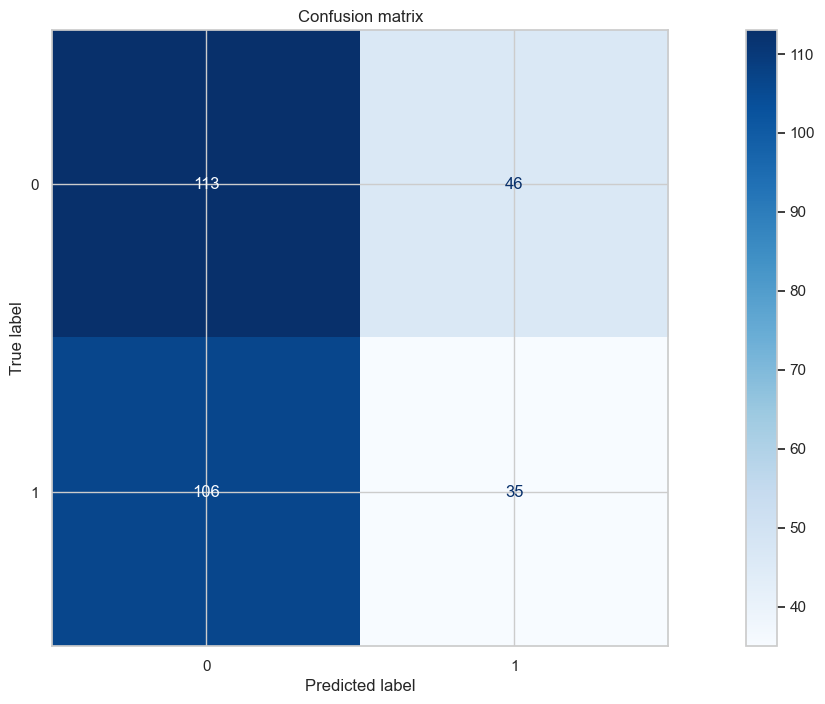

In [24]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
# display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

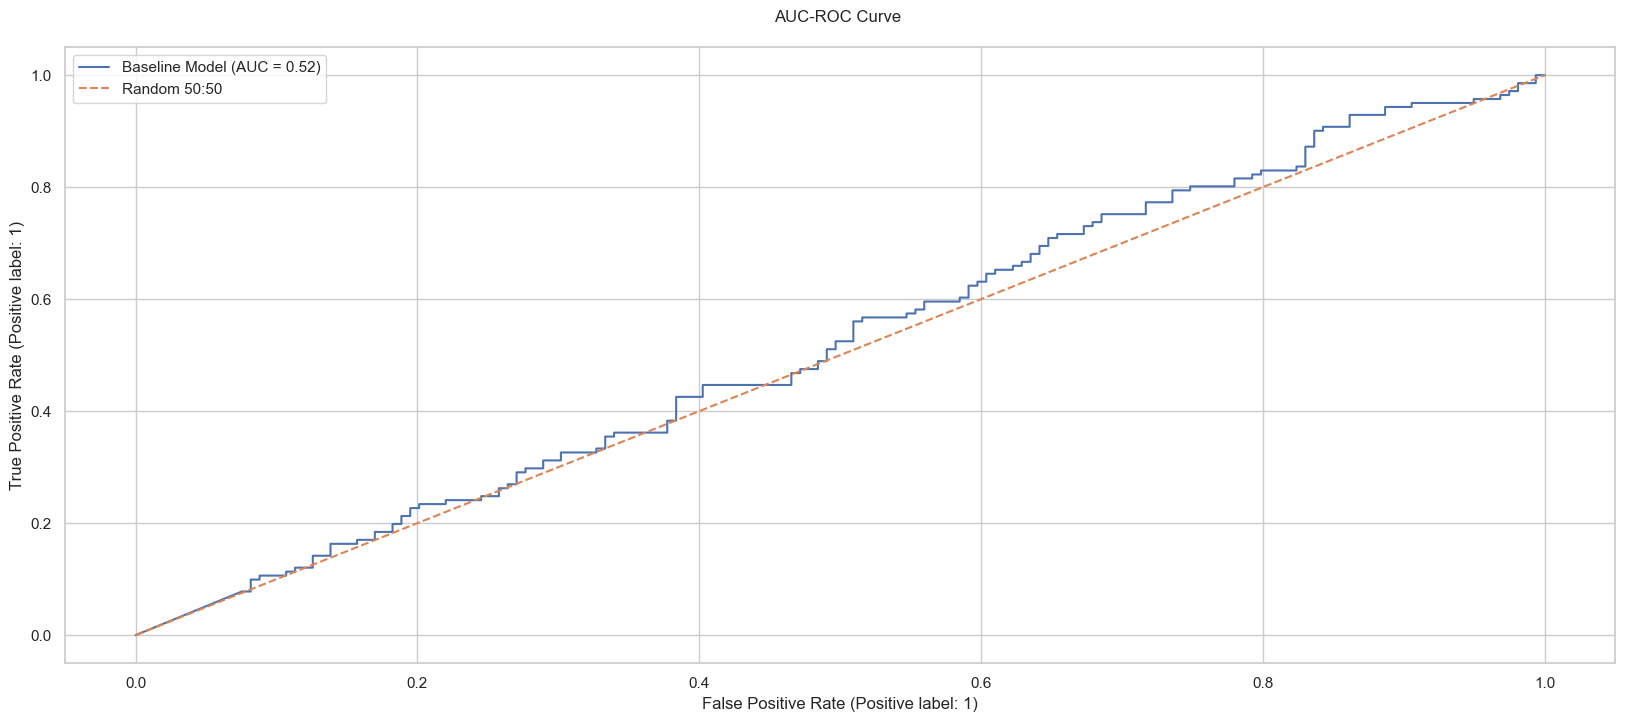

In [25]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()


In [28]:
# Classification Report
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.52      0.71      0.60       159
           1       0.43      0.25      0.32       141

    accuracy                           0.49       300
   macro avg       0.47      0.48      0.46       300
weighted avg       0.48      0.49      0.47       300




# Hyperparameter Tuning : Model Training + Evaluation

Now I use techniques -- TimeSeriesSplit to tune hyperparameters like C (regularization parameter), kernel type, gamma (for RBF kernel), etc.

In [27]:
# Get Params list
classifier.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', SVC(class_weight='balanced', probability=True))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': SVC(class_weight='balanced', probability=True),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__C': 1.0,
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifier__class_weight': 'balanced',
 'classifier__coef0': 0.0,
 'classifier__decision_function_shape': 'ovr',
 'classifier__degree': 3,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'rbf',
 'classifier__max_iter': -1,
 'classifier__probability': True,
 'classifier__random_state': None,
 'classifier__shrinking': True,
 'classifier__tol': 0.001,
 'classifier__verbose': False}

In [28]:
!pip install optuna

## 1. Tuning Target: loss minimization ##


Firstly, I employed the TimeSeriesSplit method for hyperparameter tuning, setting the tuning target to loss minimization, specifically aiming to minimize the log loss. After obtaining the optimal parameters, I trained and predicted using the original data, maintaining an 80/20 split between training and testing sets. Finally, I visualized the performance by plotting the confusion matrix and AUC-ROC curve, and measured the accuracy of the model.

  0%|          | 0/20 [00:00<?, ?it/s]

Best Params: {'svc_c': 61.79020376978541, 'kernel': 'sigmoid', 'gamma': 3.1392692899837544, 'degree': 5, 'tol': 0.0022745441649752634}, Best Value: -19.06918736418222


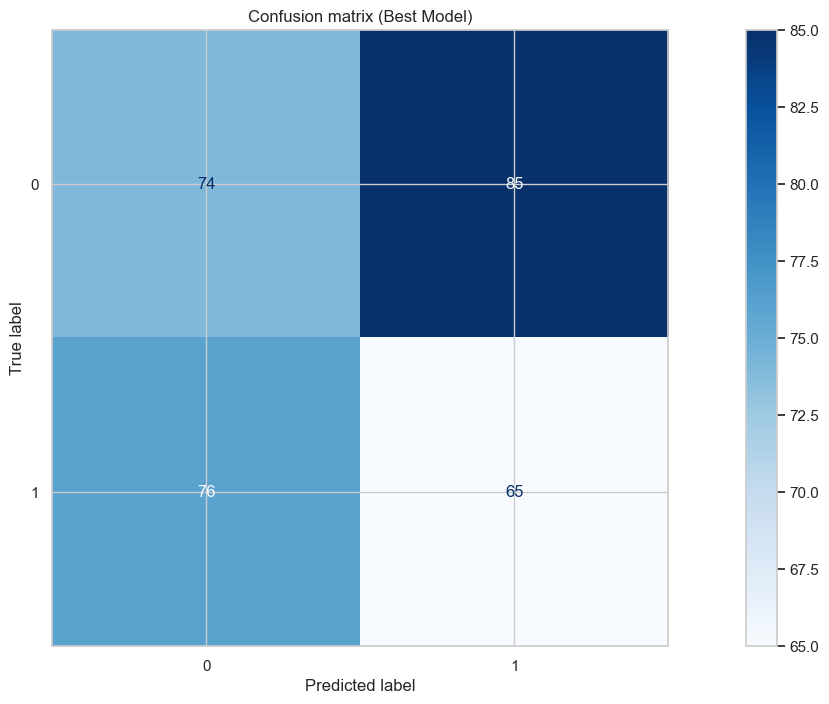

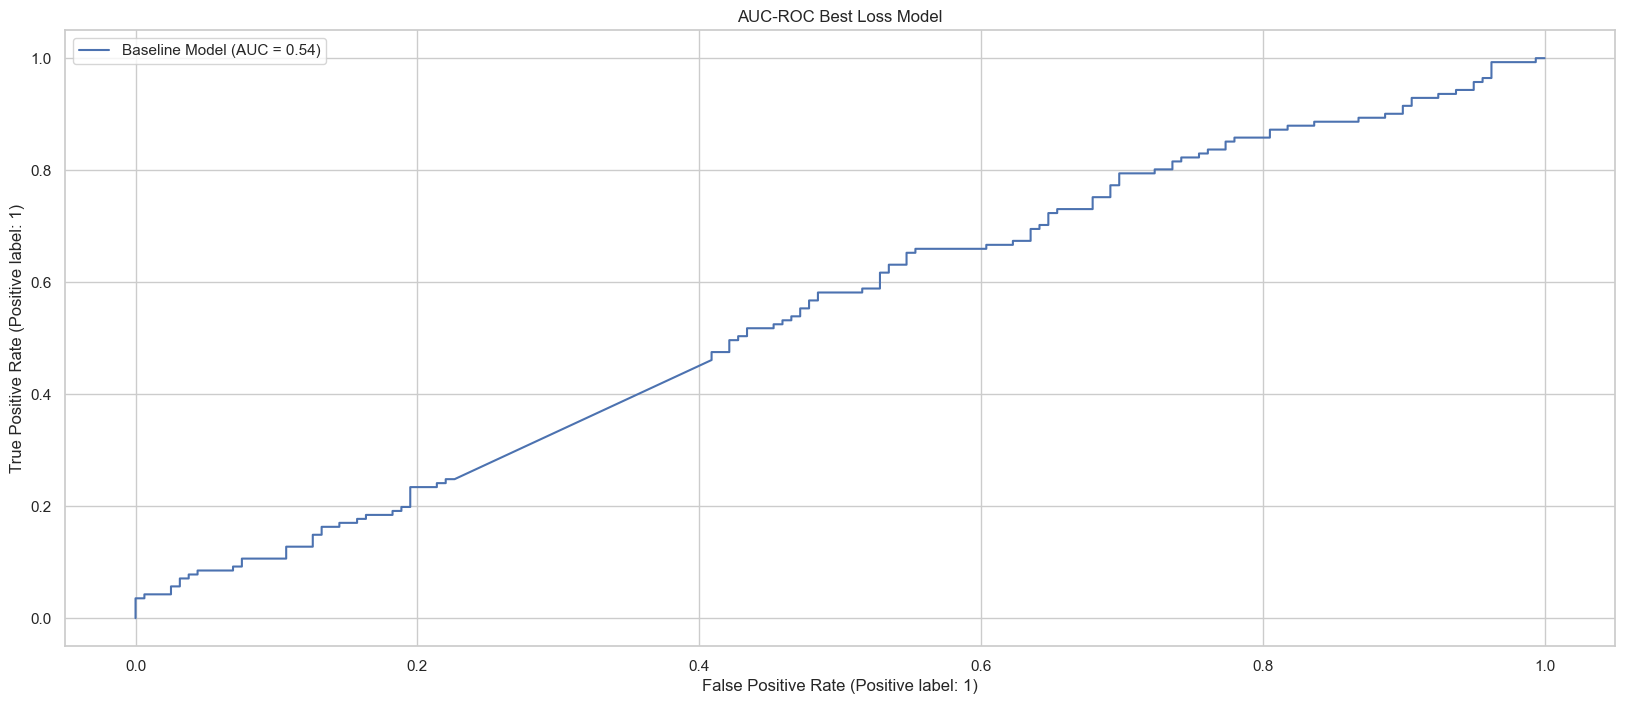


 Training Accuracy 	: 0.4833 
 Test Accuracy 		:,0.4633


In [29]:
import optuna
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

X = pd.DataFrame(X)  # Convert to DataFrame if X is a NumPy array
y = pd.Series(y)     # Convert to Series if y is a NumPy array

def optimize(trial, x, y):
    # Define the search space for parameters
    svc_c = trial.suggest_loguniform("svc_c", 1e-2, 1e2)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    gamma = trial.suggest_loguniform("gamma", 1e-3, 1e3)
    degree = trial.suggest_int('degree', 1, 5)
    tolerance = trial.suggest_float("tol", 0.001, 0.01, log=True)

    # Define the model
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(C=svc_c, kernel=kernel, gamma=gamma, degree=degree, tol=tolerance, probability=True))
    ])

   
    tscv = TimeSeriesSplit(n_splits=2, gap=5)
    ll = []
    for train_idx, test_idx in tscv.split(x):
        xtrain = x.iloc[train_idx]
        xtest = x.iloc[test_idx]
        ytrain = y.iloc[train_idx]
        ytest = y.iloc[test_idx] 
        
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        ll.append(log_loss(ytest, preds))
    
    return -1.0 * np.mean(ll)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create an Optuna Study object
study = optuna.create_study(study_name="svm_best_params", direction="minimize")

# Run the optimization
optimization_function = partial(optimize, x=X, y=y)
study.optimize(optimization_function, n_trials=20, show_progress_bar=True)

print(f'Best Params: {study.best_params}, Best Value: {study.best_value}')

# Best Model (minimized loss)
svm_best_loss = Pipeline([
    ("scaler", StandardScaler()), 
    ("classifier", SVC(C=study.best_params['svc_c'], 
                       kernel=study.best_params['kernel'], 
                       gamma=study.best_params['gamma'], 
                       degree=study.best_params['degree'], 
                       tol=study.best_params['tol'], 
                       probability=True)) 
])

svm_best_loss.fit(X_train, y_train)
# Predict Class Labels
y_pred = svm_best_loss.predict(X_test)

# Display confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    svm_best_loss,
    X_test,
    y_test,
    cmap=plt.cm.Blues)
plt.title('Confusion matrix (Best Model)')
plt.show()

# Display Roccurve

disp = RocCurveDisplay.from_estimator(
    svm_best_loss,
    X_test,
    y_test,
    name='Baseline Model')

plt.title('AUC-ROC Best Loss Model')
plt.legend()
plt.show()

# Measure Accuracy
acc_train = accuracy_score(y_train, svm_best_loss.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t:,{acc_test :0.4}')

## 2. Tuning Target: AUC Maximization ##


Secondly, I used the TimeSeriesSplit method for hyperparameter tuning, setting the tuning target to AUC maximization. AUC (Area Under the Curve) is a crucial metric for evaluating the performance of classification models, providing a clear indication of the model's ability to distinguish between positive and negative samples. After obtaining the optimal parameters, I trained and predicted using the original data, maintaining an 80/20 split between training and testing sets. Finally, I visualized the model's performance by plotting the confusion matrix and AUC-ROC curve, and measured the accuracy.

  0%|          | 0/20 [00:00<?, ?it/s]

Best Parameters: {'svc_c': 0.5207797164548906, 'kernel': 'linear', 'gamma': 0.01379964961423783, 'degree': 4, 'tol': 0.001543166548875786}, Best Value: 0.522059590130505


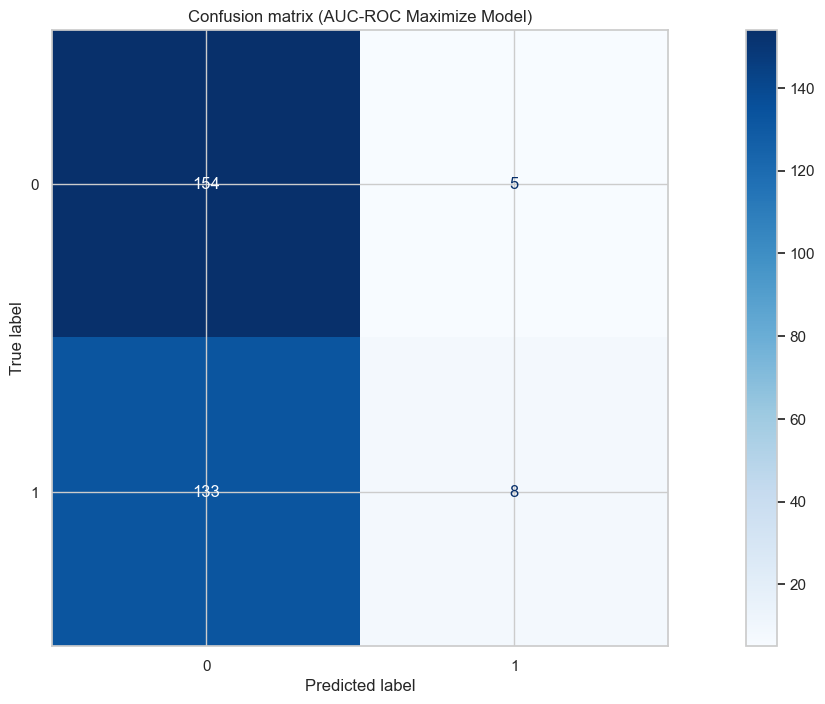

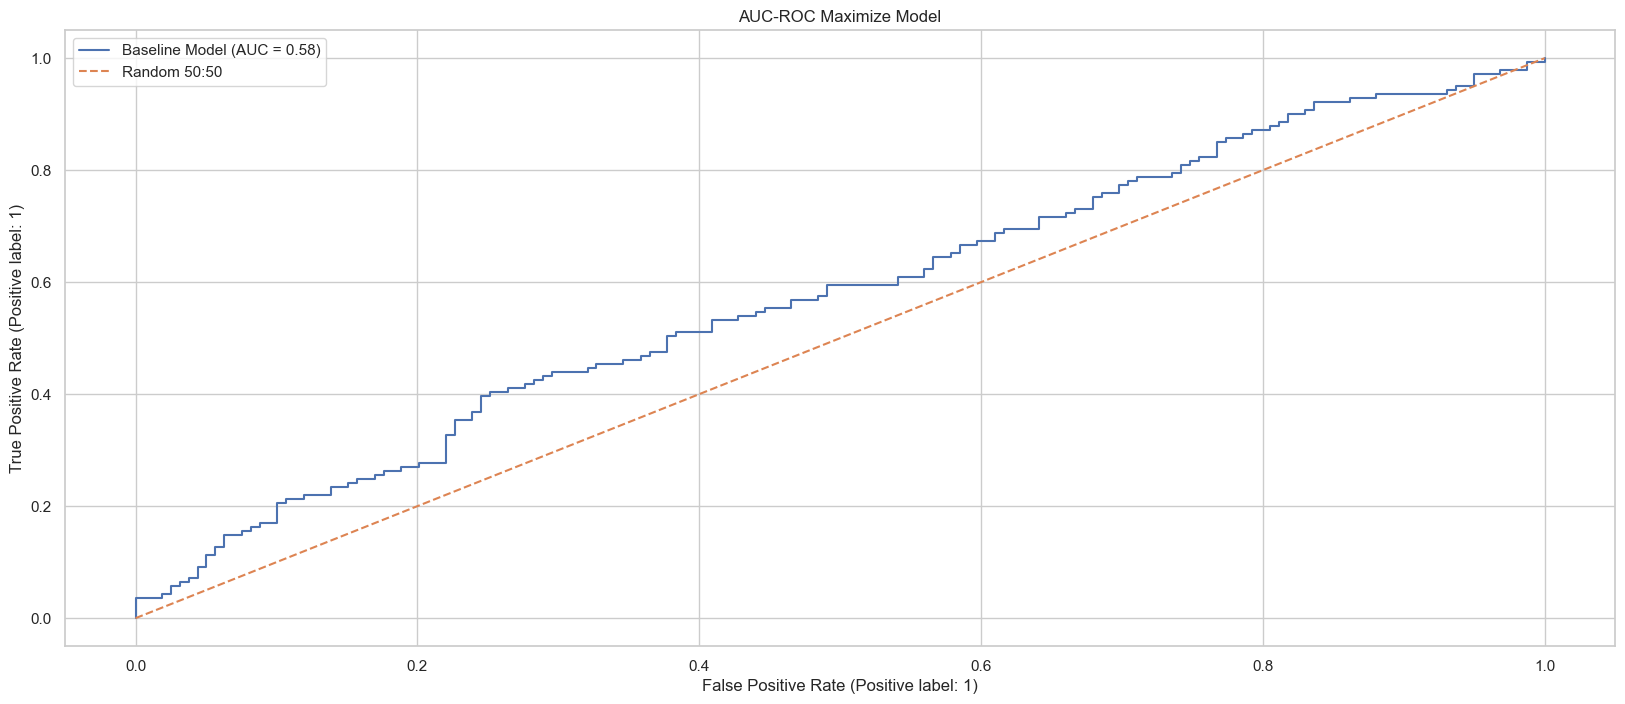

Accuracy: 0.54 




In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from functools import partial
import optuna

X = pd.DataFrame(X)  # Convert to DataFrame if X is a NumPy array
y = pd.Series(y)     # Convert to Series if y is a NumPy array

# Define the optimization function
def optimize(trial, x, y):
    # Define the parameter search space
    svc_c = trial.suggest_loguniform("svc_c", 1e-2, 1e2)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    gamma = trial.suggest_loguniform("gamma", 1e-3, 1e3)
    degree = trial.suggest_int('degree', 1, 5)
    tolerance = trial.suggest_float("tol", 0.001, 0.01, log=True)

    # Define the model
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", SVC(C=svc_c, kernel=kernel, gamma=gamma, degree=degree, tol=tolerance, probability=True))
    ])
    
    tscv = TimeSeriesSplit(n_splits=2, gap=5)
    auc_scores = []
    
    # Evaluate model performance
    for train_idx, test_idx in tscv.split(x):
        xtrain = x.iloc[train_idx]
        xtest = x.iloc[test_idx]
        ytrain = y.iloc[train_idx]
        ytest = y.iloc[test_idx] 
        
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)

        auc_scores.append(roc_auc_score(ytest, preds))
    
    # Return the average AUC score as the optimization target
    return np.mean(auc_scores)

# Set Optuna logging level
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create Optuna study object
study = optuna.create_study(study_name="svm_best_params_auc", direction="maximize")

# Run the optimization
optimization_function = partial(optimize, x=X, y=y)
study.optimize(optimization_function, n_trials=20, show_progress_bar=True)

print(f'Best Parameters: {study.best_params}, Best Value: {study.best_value}')

# Best Model (AUC Maximize model)
Auc_best = Pipeline([
    ("scaler", StandardScaler()), 
    ("classifier", SVC(C=study.best_params['svc_c'], 
                       kernel=study.best_params['kernel'], 
                       gamma=study.best_params['gamma'], 
                       degree=study.best_params['degree'], 
                       tol=study.best_params['tol'], 
                       probability=True)) 
])

Auc_best.fit(X_train, y_train)

# Display confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    Auc_best,
    X_test,
    y_test,
    cmap=plt.cm.Blues)
plt.title('Confusion matrix (AUC-ROC Maximize Model)')
plt.show()

# Display ROC curve
disp = RocCurveDisplay.from_estimator(
    Auc_best,
    X_test,
    y_test,
    name='Baseline Model')

plt.title('AUC-ROC Maximize Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random 50:50')
plt.legend()
plt.show()

# Accuracy
accuracy = Auc_best.score(X_test, y_test)
print('Accuracy:', accuracy, '\n\n')

## 3. Tuning Target: Accuracy Maximization ##

Lastly, I utilized the TimeSeriesSplit method for hyperparameter tuning, setting the tuning target to accuracy maximization. Accuracy is one of the fundamental metrics for evaluating the performance of classification models, representing the proportion of correctly predicted samples out of all samples. It considers all prediction results (including both positive and negative classes) and comprehensively reflects the overall performance of the model. After obtaining the optimal parameters, I trained and predicted using the original data, maintaining an 80/20 split between training and testing sets. Finally, I visualized the model's performance by plotting the confusion matrix and AUC-ROC curve, and measured the accuracy.

  0%|          | 0/20 [00:00<?, ?it/s]

Best Parameters: {'svc_c': 0.5514607619814164, 'kernel': 'poly', 'gamma': 10.228144198011604, 'degree': 4, 'tol': 0.001462838947962826}, Best Value: 0.5440881763527055


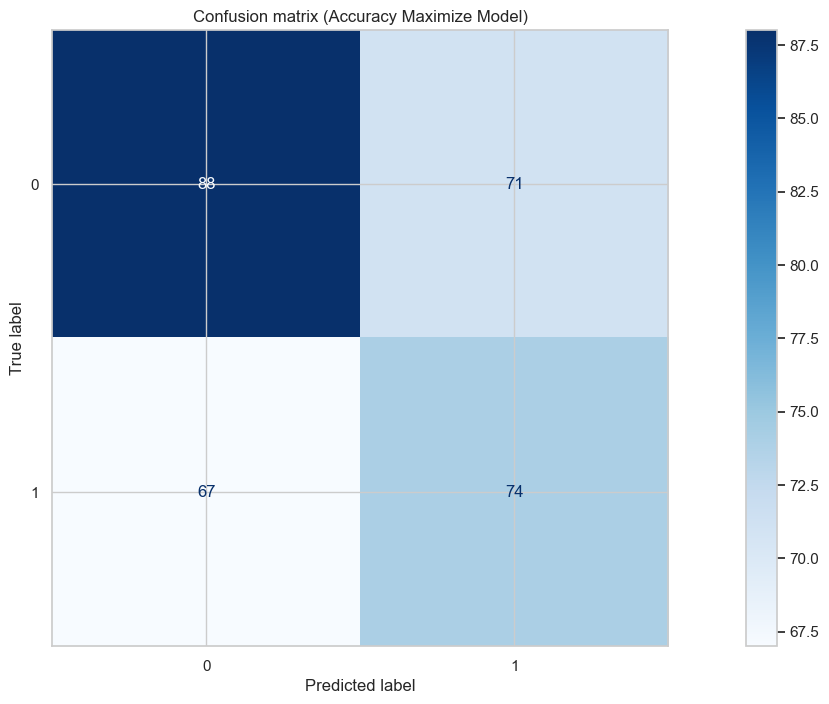

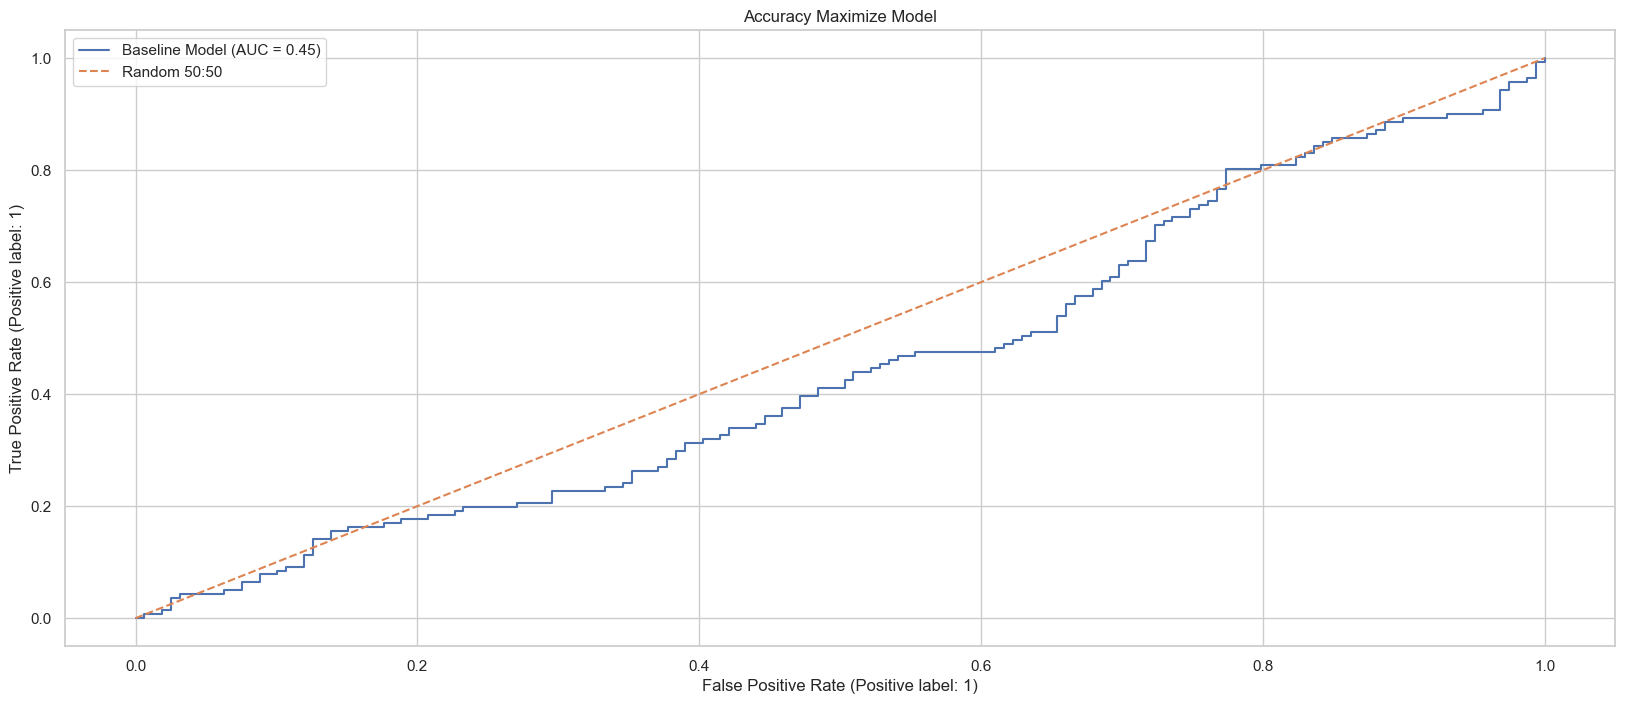

Accuracy: 0.54 




In [28]:
import optuna
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Best Accuracy Model

X = pd.DataFrame(X)  # Convert to DataFrame if X is a NumPy array
y = pd.Series(y)     # Convert to Series if y is a NumPy array

def optimize(trial, x, y):
    # Define the search space for parameters
    svc_c = trial.suggest_loguniform("svc_c", 1e-2, 1e2)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    gamma = trial.suggest_loguniform("gamma", 1e-3, 1e3)
    degree = trial.suggest_int('degree', 1, 5)
    tolerance = trial.suggest_float("tol", 0.001, 0.01, log=True)

    # Define the model
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", SVC(C=svc_c, kernel=kernel, gamma=gamma, degree=degree, tol=tolerance, probability=True))
    ])

 # Define rolling window split parameters
    tscv = TimeSeriesSplit(n_splits=2, gap=5)
    accuracy_scores = []
    
    for train_idx, test_idx in tscv.split(x):
        xtrain = x.iloc[train_idx]
        xtest = x.iloc[test_idx]
        ytrain = y.iloc[train_idx]
        ytest = y.iloc[test_idx] 
        
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)

        accuracy_scores.append(accuracy_score(ytest, preds))
    return np.mean(accuracy_scores)

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create Optuna study object
study = optuna.create_study(study_name="svm_best_params_acc", direction="maximize")

# Run the optimization
optimization_function = partial(optimize, x=X, y=y)
study.optimize(optimization_function, n_trials=20, show_progress_bar=True)

print(f'Best Parameters: {study.best_params}, Best Value: {study.best_value}')

# Best Model (AUC Maximize model)
Acc_best = Pipeline([
    ("scaler", StandardScaler()), 
    ("classifier", SVC(C=study.best_params['svc_c'], 
                       kernel=study.best_params['kernel'], 
                       gamma=study.best_params['gamma'], 
                       degree=study.best_params['degree'], 
                       tol=study.best_params['tol'], 
                       probability=True)) 
])

Acc_best.fit(X_train, y_train)

# Display confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    Acc_best,
    X_test,
    y_test,
    cmap=plt.cm.Blues)
plt.title('Confusion matrix (Accuracy Maximize Model)')
plt.show()

# Display ROC curve
disp = RocCurveDisplay.from_estimator(
    Acc_best,
    X_test,
    y_test,
    name='Baseline Model')

plt.title('Accuracy Maximize Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random 50:50')
plt.legend()
plt.show()

# Accuracy
accuracy = Acc_best.score(X_test, y_test)
print('Accuracy:', accuracy, '\n\n')

## Conclusion ##

After conducting parameter tuning and model analysis with three different objectives, I believe that the best model is the one optimized for AUC Maximization. This conclusion is based on several compelling reasons:

1. Superior Model Performance: The model optimized for AUC maximization demonstrates the highest AUC value, indicating that it has the best overall ability to distinguish between positive and negative classes. This higher AUC value translates to better model discrimination capability, meaning the model can more effectively differentiate between stocks that will rise and those that will fall. A high AUC value is particularly crucial in the financial domain, where the ability to accurately identify true positives (profitable investments) and true negatives (losses to avoid) can significantly impact investment strategies and outcomes.

2. Clear Accuracy Classification: Additionally, the accuracy classification of this model is very clear. For instance, when the true label is 0 (indicating that a stock will not rise), the model's prediction of label 0 is significantly higher than label 1. This indicates that when the real situation is a stock decline, the model rarely predicts an increase, thus avoiding misleading investors into making high-priced purchases. Although the model tends to predict a decline when the stock is actually rising, this conservative approach is beneficial in risk management. It minimizes the risk of overestimating stock performance and encourages cautious investment, which is often a safer strategy in volatile markets. By predicting downturns more frequently, the model helps prevent investors from making potentially costly mistakes driven by overly optimistic forecasts.

3. Risk Management and Investor Protection: While it is true that the model may predict a downturn even when the stock is poised to rise, this cautious bias serves as a protective mechanism for investors. It reduces the likelihood of making risky investments based on false positives, thereby safeguarding investor capital. In the context of financial markets, where losses can be substantial, this conservative approach can prevent significant financial harm. The cost of missing out on some gains is outweighed by the benefit of avoiding substantial losses, making this model particularly suitable for risk-averse investors or those looking to maintain a more conservative investment strategy.

In summary, I believe that the model optimized for AUC maximization is the best choice. Its superior ability to discriminate between positive and negative classes, combined with its clear and cautious accuracy classification, makes it the most reliable and beneficial model for guiding investment decisions. This model not only enhances predictive performance but also provides a robust framework for managing investment risks, ultimately protecting investors from potential losses and ensuring more informed and safer investment choices.